In [1]:
from importlib import reload

In [2]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image, display

from dowhy import CausalModel

In [3]:
pd.set_option("mode.chained_assignment", None)

In [4]:
import futil, load_util

In [5]:
wdi_df, series_df = load_util.load_wdi()
project_df = load_util.load_projects()
wb_df = load_util.extract_wb_projects(project_df)

In [6]:
odi_and_gdp_indicators = [
    'DT.ODA.ODAT.GN.ZS',
    'NY.GDP.MKTP.CD' # divide project size at time
]

education_expense_indicators = [
    'SE.XPD.PRIM.ZS',
    'SE.XPD.SECO.ZS',
    'SE.XPD.TERT.ZS'
]

education_outcome_indicators = [
    'SE.PRM.NENR', 
    'SE.PRM.CMPT.ZS', 
    'SE.PRM.PRSL.ZS'
]

## Constructing time gaps

In [7]:
sector_aggs = project_df.groupby('sector').agg(
    number_projects=('ppd_project_id', 'nunique'),
    earliest_year=('start_dt', 'min'),
    latest_project=('start_dt', 'max'),
    number_donors=('donor_name', 'nunique'),
    avg_rating=('six_overall_rating', 'mean'),
    avg_duration=('project_duration', 'mean')
)

In [8]:
feature_cols = [
    'country_code', 
    'donor_name', 
    'aiddata_sectorname', 
    'six_overall_rating', 
    'start_date', 
    'completion_date', 
    'project_duration',
    'sector'
]

pdf = load_util.narrow_convert_project_data(project_df, feature_cols)

total_countries = pdf.country_code.nunique()
earliest_year = pdf.start_year.min()
latest_year = pdf.start_year.max()
year_range = range(int(earliest_year), int(latest_year))

In [9]:
futil.calc_sector_controls(pdf, 'Education', 1990, year_range)

## First approach: binary treatment, replicating papers on causal structure

### Assemble education panel

In [10]:
# load in panel assembled by DG

In [11]:
ddf = pd.read_csv('../data/countrypanel.csv')

In [12]:
# for each country-year, calculate mean growth in education indicators at year + lag

In [13]:
ccode_corr = pd.read_csv('../data/PPD_WDI_country_codes.csv')

In [14]:
ccode_corr.head()

,ppd_countrycode,ppd_countryname,wdi_countrycode,wdi_countryname
0,AAB,Antigua & Barbuda,ATG,Antigua and Barbuda
1,AFG,Afghanistan,AFG,Afghanistan
2,ALB,Albania,ALB,Albania
3,ALG,Algeria,DZA,Algeria
4,ANG,Angola,AGO,Angola


In [15]:
pdf.head()

,country_code,donor_name,aiddata_sectorname,six_overall_rating,start_date,completion_date,project_duration,sector,start_dt,start_year,completion_dt,end_year
0,CHN,AsianDB,NaN,4.5,26nov1996,01jan2003,2555.0,Wash,1996-11-26,1996.0,2003-01-01,2003.0
1,COO,AsianDB,NaN,4.5,20sep1990,01jan1995,1825.0,Telecom,1990-09-20,1990.0,1995-01-01,1995.0
2,PHI,AsianDB,NaN,1.5,24jan1989,01jan1995,2190.0,Wash,1989-01-24,1989.0,1995-01-01,1995.0
3,NEP,AsianDB,NaN,4.5,22dec1978,01jan1996,6570.0,Transport,1978-12-22,1978.0,1996-01-01,1996.0
4,SRI,AsianDB,NaN,4.5,23jul1991,01jan1996,1825.0,Finance,1991-07-23,1991.0,1996-01-01,1996.0


In [26]:
df, tdf = futil.assemble_sectoral_df(
    pdf, 
    education_outcome_indicators,
    year_range,
    interpolate_limit=5,
#     persisted_lag_table=None,
    persisted_lag_table='../data/transformed_data/education_df.csv'
)

In [28]:
df = df.merge(ccode_corr[['ppd_countrycode', 'wdi_countrycode', 'wdi_countryname']], left_on='country',
               right_on='ppd_countrycode', how='left')

In [31]:
df['country_code'] = df['wdi_countrycode']
df = df[df['country_code'].notna()].drop(columns=['wdi_countrycode', 'country_code'])

In [32]:
df.head()

,year,country,project_completed_year,education_lag_1_growth,education_lag_1_count,education_lag_2_growth,education_lag_2_count,education_lag_3_growth,education_lag_3_count,education_lag_4_growth,...,FP.CPI.TOTL.ZG,GC.NLD.TOTL.GD.ZS,NE.TRD.GNFS.ZS,NY.GDP.PCAP.KD,NY.GDP.PCAP.PP.KD,SE.XPD.TOTL.GB.ZS,SP.POP.0014.TO.ZS,SP.POP.TOTL,ppd_countrycode,wdi_countryname
0,1956,CHN,False,NaN,0,NaN,0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHN,China
2,1956,PHI,False,NaN,0,NaN,0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHI,Philippines
3,1956,NEP,False,NaN,0,NaN,0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEP,Nepal
4,1956,SRI,False,NaN,0,NaN,0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRI,Sri Lanka
5,1956,TON,False,NaN,0,NaN,0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TON,Tonga


In [28]:
stored_df = pd.read_csv('../data/transformed_data/education_df.csv')

In [15]:
# na_counts = tdf.groupby(['Year', 'Indicator Code']).agg(num_rows=('na_value', 'count'), num_na=('na_value', 'sum')).reset_index()
# na_counts['ratio_values_present'] = 1 - na_counts['num_na'] / na_counts['num_rows']
# na_counts.plot.line(y='ratio_values_present', x='Year')

In [30]:
non_data_cols = ['year', 'country', 'project_completed_year']
data_cols = [col for col in stored_df.columns if col not in non_data_cols]
null_df = stored_df.copy()
null_df = null_df[null_df.year > 1990]
null_df[data_cols] = null_df[data_cols].isna()
null_df['number_missing'] = null_df[data_cols].sum(axis=1)

In [31]:
null_df.head()

,year,country,project_completed_year,education_lag_-4_growth,most_recent_govt_rating,FP.CPI.TOTL.ZG,GC.NLD.TOTL.GD.ZS,NE.TRD.GNFS.ZS,NY.GDP.PCAP.KD,NY.GDP.PCAP.PP.KD,SE.XPD.TOTL.GB.ZS,SP.POP.0014.TO.ZS,SP.POP.TOTL,number_missing
6160,1991,CHN,False,True,False,False,True,False,False,False,True,False,False,3
6161,1991,COO,False,True,True,True,True,True,True,True,True,True,True,10
6162,1991,PHI,False,True,False,True,True,True,True,True,True,True,True,9
6163,1991,NEP,False,True,False,True,True,True,True,True,True,True,True,9
6164,1991,SRI,False,True,False,True,True,True,True,True,True,True,True,9


<AxesSubplot:>

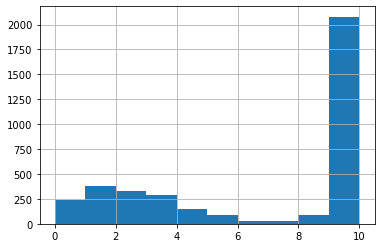

In [32]:
null_df['number_missing'].hist()

In [103]:
null_df[non_data_cols].nunique()

year                       21
country                   176
project_completed_year      2
dtype: int64

In [104]:
null_df['number_missing'].value_counts().to_dict()

In [115]:
def extract_culprit_counts(null_df, data_cols):
    clean_number_base = null_df['number_missing'].value_counts().to_dict()[0]
    culprit_counts = {}
    for test_col in data_cols:
        tmp_cols = [col for col in data_cols if col != test_col]
        temp_df = null_df.drop(columns=[test_col])
        temp_df['number_missing'] = temp_df[tmp_cols].sum(axis=1)
        new_clean = temp_df['number_missing'].value_counts().to_dict()[0]
        culprit_counts[test_col] = new_clean - clean_number_base
        
    return culprit_counts

In [105]:
culprit_counts = extract_culprit_counts(null_df, data_cols)
culprit_counts

In [107]:
series_df[series_df['Series Code'].isin(culprit_counts.keys())][['Series Code', 'Topic', 'Indicator Name']]

,Series Code,Topic,Indicator Name
317,FP.CPI.TOTL.ZG,Financial Sector: Exchange rates & prices,"Inflation, consumer prices (annual %)"
347,GC.NLD.TOTL.GD.ZS,Public Sector: Government finance: Deficit & f...,Net lending (+) / net borrowing (-) (% of GDP)
594,NE.TRD.GNFS.ZS,Economic Policy & Debt: National accounts: Sha...,Trade (% of GDP)
683,NY.GDP.PCAP.KD,Economic Policy & Debt: National accounts: US$...,GDP per capita (constant 2010 US$)
687,NY.GDP.PCAP.PP.KD,Economic Policy & Debt: Purchasing power parity,"GDP per capita, PPP (constant 2017 internation..."
902,SE.XPD.TOTL.GB.ZS,Education: Inputs,"Government expenditure on education, total (% ..."
1265,SP.POP.0014.TO.ZS,Health: Population: Structure,Population ages 0-14 (% of total population)
1317,SP.POP.TOTL,Health: Population: Structure,"Population, total"


In [85]:
ddf = pd.read_csv('../data/countrypanel.csv')
ddf.head()

In [109]:
ddf_data_cols = [col for col in ddf.columns if col not in ['year', 'countrycode', 'regionname', 'fcv_ind', 'lendingtype', 'incomelevel']]
nddf = ddf.copy()
nddf[ddf_data_cols] = nddf[ddf_data_cols].isna()
nddf['number_missing'] = nddf[ddf_data_cols].sum(axis=1)

In [110]:
nddf.head()

,year,countrycode,countryname,regionname,fcv_ind,lendingtype,incomelevel,pc_commit_total,pc_commit_education,pc_commit_health,...,hiv_prevalence,health_share_gov_exp,cash_surplus_deficit,access_water,access_sanitation,political_rights,civil_liberties,conflict,freedom_house,number_missing
0,1990,AFG,False,South Asia,FCS,IDA,LIC,False,False,False,...,False,True,True,True,True,False,False,False,False,15
1,1991,AFG,False,South Asia,FCS,IDA,LIC,False,False,False,...,False,True,True,False,False,False,False,False,False,13
2,1992,AFG,False,South Asia,FCS,IDA,LIC,False,False,False,...,False,True,True,False,False,False,False,False,False,13
3,1993,AFG,False,South Asia,FCS,IDA,LIC,False,False,False,...,False,True,True,False,False,False,False,False,False,10
4,1994,AFG,False,South Asia,FCS,IDA,LIC,False,False,False,...,False,True,True,False,False,False,False,False,False,13


In [112]:
nddf['number_missing'].value_counts().to_dict()

In [116]:
extract_culprit_counts(nddf, ddf_data_cols)

{'countryname': 0,
 'pc_commit_total': 0,
 'pc_commit_education': 0,
 'pc_commit_health': 0,
 'pc_commit_wash': 0,
 'commit_total': 0,
 'commit_education': 0,
 'commit_health': 0,
 'commit_wash': 0,
 'population': 0,
 'young_population': 0,
 'fertility': 0,
 'oda_share_gni': 0,
 'oda_pc': 0,
 'gdp_pc': 0,
 'gdp_pc_ppp': 0,
 'inflation': 14,
 'trade_share_gdp': 19,
 'edu_ner': 0,
 'edu_aner': 1,
 'edu_completion': 24,
 'edu_share_gov_exp': 37,
 'edu_pupil_teacher': 7,
 'female_adult_literacy': 0,
 'adult_literacy': 0,
 'physicians_rate': 8,
 'mortality_under5': 0,
 'immunization': 0,
 'life_expectancy': 0,
 'hiv_prevalence': 83,
 'health_share_gov_exp': 53,
 'cash_surplus_deficit': 214,
 'access_water': 0,
 'access_sanitation': 0,
 'political_rights': 0,
 'civil_liberties': 0,
 'conflict': 0,
 'freedom_house': 0}

In [117]:
merged_df = stored_df.merge(ddf[['countrycode', 'year', 'cash_surplus_deficit']], left_on=['country', 'year'], 
                            right_on=['countrycode', 'year'])

merged_df['deficit_na'] = merged_df['GC.NLD.TOTL.GD.ZS'].isna().astype(int) + merged_df['cash_surplus_deficit'].isna().astype(int)
merged_df.deficit_na.value_counts()

In [155]:
ddf_ccodes = ddf.groupby(['countrycode', 'countryname'], as_index=False).agg(rows=('year', 'count'))
ddf_ccodes['honig_match'] = ddf_ccodes['countrycode'].isin(project_df.country_code)
ddf_ccodes

,countrycode,countryname,rows,honig_match
0,AFG,Afghanistan,24,True
1,AGO,Angola,24,False
2,ALB,Albania,24,True
3,ARG,Argentina,24,True
4,ARM,Armenia,24,True
...,...,...,...,...
131,WSM,Samoa,24,True
132,YEM,"Yemen, Republic of",24,True
133,ZAF,South Africa,24,False
134,ZMB,Zambia,24,False


In [156]:
project_data_ccodes = project_df.groupby(['country_code'], as_index=False).agg(proj_count=('ppd_project_id', 'nunique'))
project_data_ccodes['panel_match'] = project_data_ccodes['country_code'].isin(ddf.countrycode)
project_data_ccodes.head()

,country_code,proj_count,panel_match
0,AAB,3,False
1,AFG,135,True
2,ALB,93,True
3,ALG,72,False
4,ANG,24,False


In [160]:
print('Honig matches in panel: ', ddf_ccodes.honig_match.sum() / len(ddf_ccodes))
print('Panel matches in Honig: ', project_data_ccodes.panel_match.sum() / len(project_data_ccodes))

Honig matches in panel:  0.45588235294117646
Panel matches in Honig:  0.3522727272727273


In [157]:
store_ccode_mismatch = False

if store_ccode_mismatch:
    ddf_ccodes.to_csv('../data/panel_country_codes.csv', index=False)
    project_data_ccodes.to_csv('../data/honig_country_codes.csv', index=False)

In [ ]:
# ddata_cols = [col for col in ddf.columns if col not in ['year', 'countrycode', '']]

In [16]:
tdf.head()

,Country Code,Indicator Code,Year,value
0,ARB,SE.PRM.PRSL.ZS,1990,84.182720
1,ARB,SE.PRM.CMPT.ZS,1990,68.912369
2,ARB,SE.PRM.NENR,1990,72.386398
3,CSS,SE.PRM.PRSL.ZS,1990,83.209790
4,CSS,SE.PRM.CMPT.ZS,1990,94.996964


In [ ]:
edu_proj, df = futil.assemble_sector_proj_df(project_df, 'Education', df)

In [ ]:
df = futil.construct_sector_lag_table(df, tdf, pdf, education_outcome_indicators, 'Education')

In [ ]:
df.head()

In [ ]:
print('Total projects: ', len(pdf))
print('Years with sufficient coverage on lag: ', len(df[(df.education_lag_4_count > 0)]))
df.project_completed_year.value_counts()

In [ ]:
# then: add in the various confounders, treatments, controlsc

In [ ]:
# first : country rating
def find_latest_govt_rating(country, year):
    country_proj = project_df[
        (project_df['country_code'] == country) 
        & (project_df['start_year'] <= year)
        & (project_df['wb_government_partner_rating'].notna())]
    if len(country_proj) == 0:
        return np.nan
    else:
        proj_year = country_proj[country_proj.start_year == country_proj.start_year.max()]
        return proj_year['wb_government_partner_rating'].sort_values(ascending=False).iloc[0]

if 'most_recent_govt_rating' not in df:
    df['most_recent_govt_rating'] = df.apply(lambda row: find_latest_govt_rating(row['country'], row['year']), axis=1)

df.most_recent_govt_rating.value_counts()

Education: Specification 2
```
regress  last_ner <- first_ner pc_commit_education [per capita commitment amount=
        edu_share_gov_exp edu_pupil_teacher young_population
        gdp_pc_ppp cash_surplus_deficit inflation trade_share_gdp
        freedom_house i.period i.ncountrycode if countrytoinclude == 1, r
```

In [ ]:
# the commitment amounts will come from aid data (and are the original exogs)
other_input_variables = [
    'SP.POP.TOTL', 
    'SP.POP.0014.TO.ZS', # young population
    'NY.GDP.PCAP.KD',
    'NY.GDP.PCAP.PP.KD', # gdp per cap PPP
    'FP.CPI.TOTL.ZG', # inflation
    'NE.TRD.GNFS.ZS', # trade share of GDP,
#     'SE.PRM.ENRL.TC.ZS', # teacher-pupil share (? - should be in outcome)
    'SE.XPD.TOTL.GB.ZS', # govt share of education,
    'GC.NLD.TOTL.GD.ZS' # note: discontinued cash surplus/balance, and not in MDG, so use this
]

*Note*: There is no surplus deficit in the standard WDI, so using net borrowing in year (is available)

In [ ]:
feature_frame = futil.extract_indicators(wdi_df, other_input_variables)

In [ ]:
feature_df = futil.melt_interpolate_df(feature_frame, interpolate_limit=2, drop_columns=['Country Name', 'Indicator Name', 'Unnamed: 65'])

In [ ]:
present_counts = feature_df['Indicator Code'].value_counts().to_dict()
var_count = { key: present_counts.get(key, 0) for key in other_input_variables }
var_count

In [ ]:
feature_df.head()

In [ ]:
# pf_df = feature_df.pivot(columns=['Country Code', 'Year'])
pf_df = feature_df.groupby(['Country Code', 'Year', 'Indicator Code'])['value'].max().unstack()
pf_df = pf_df.reset_index()
pf_df.head()

In [ ]:
df.head()

In [ ]:
pf_df['Year'] = pf_df['Year'].astype(int)

In [ ]:
df = df.merge(pf_df, how='left', left_on=['year', 'country'], right_on=['Year', 'Country Code'])

In [ ]:
df = df.drop(columns=['Country Code', 'Year'], errors='ignore')
df.head()

In [ ]:
save_df = True

if save_df:
    df.to_csv('../data/transformed_data/education_df.csv', index=False)

## Some vanilla OLS

In [ ]:
import statsmodels.api as sm

In [ ]:
df.head()

In [ ]:
df.isna().sum() / len(df)

In [ ]:
# Adding categorical variables for country, for replication purposes, although means dimensionality explosion (for unclear gain)

In [ ]:
ols_df = pd.concat((df, pd.get_dummies(df['country'], drop_first=True)), axis=1)

In [ ]:
ols_df.head()

In [ ]:
drop_cols = [f'education_lag_{i}_count' for i in range(1, 10)]
drop_cols += [f'education_lag_{i}_growth' for i in range(1, 10)]
drop_cols += ['education_lag_-4_count']

In [ ]:
ols_df.drop(columns=drop_cols, errors='ignore').columns

In [ ]:
target_col = 'education_lag_4_growth'

In [ ]:
len(ols_df)

In [ ]:
data = ols_df.drop(columns=drop_cols + ['most_recent_govt_rating'])

In [ ]:
data.isna().sum()

In [ ]:
len(data)

In [ ]:
y = ols_df[target_col]
x = ols_df.drop(columns=drop_cols)

In [ ]:
sm.OLS.fit(y, x)

# Execute do-why

In [ ]:
df['sector_delta_prior'] = df['education_lag_-4_growth']
df['sector_delta_post'] = df['education_lag_4_growth']

In [ ]:
sectoral_effect_graph_binary = """digraph { 
    "Govt-Quality"[latent];
    project_completed_year [exposure, label="project_completed"];
    sector_delta_prior [adjusted, label="sector_outcome_growth_prior"];
    sector_delta_post [outcome, label=sector_outcome_growth_lagged];
    most_recent_govt_rating [label="WBGovtRating"];
    "Govt-Quality" -> project_completed_year;
    "Govt-Quality" -> sector_delta_prior;
    "Govt-Quality" -> most_recent_govt_rating;
    project_completed_year -> sector_delta_post;
    sector_delta_prior -> sector_delta_post;
    most_recent_govt_rating -> project_completed_year;
    }"""

In [ ]:
causal_columns = ['sector_delta_prior', 'most_recent_govt_rating', 'project_completed_year', 'sector_delta_post']

In [ ]:
causal_df = df[causal_columns]
pre_drop_N = len(causal_df)
causal_df = causal_df.dropna()
post_drop_N = len(causal_df)

print("N pre NA drop: ", pre_drop_N, " and post: ", post_drop_N)

In [ ]:
causal_df.project_completed_year.value_counts()

In [ ]:
model = CausalModel(
    data=causal_df,
    graph=sectoral_effect_graph_binary.replace("\n", " "),
    treatment="project_completed_year",
    outcome="sector_delta_post"
)

model.view_model()
display(Image(filename="causal_model.png"))

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

In [ ]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression",
                                 target_units="ate", test_significance=True)
print(estimate)

In [ ]:
causal_df.head()

In [ ]:
estimator_list = ["backdoor.propensity_score_matching", "backdoor.propensity_score_weighting", "backdoor.causalml.inference.meta.LRSRegressor"]
method_params= [ None, None, { "init_params":{} } ]

In [ ]:
refuter_list = ["bootstrap_refuter", "data_subset_refuter"]

In [ ]:
# for estimator, method_params in zip(estimator_list, method_params):
#     estimate = model.estimate_effect(identified_estimand, method_name=estimator, method_params=method_params)

In [ ]:
refuter = model.refute_estimate(identified_estimand, estimate, method_name="bootstrap_refuter")

In [ ]:
print(refuter)

In [ ]:
run_refuter = lambda refuter_name, refuter_params: model.refute_estimate(identified_estimand, estimate, method_name=refuter_name, **refuter_params)

In [ ]:
# c_cause_refuter = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
c_cause_refuter = run_refuter("random_common_cause", {})

In [ ]:
print(c_cause_refuter)

In [ ]:
placebo_refuter = run_refuter("placebo_treatment_refuter", dict(placebo_type="permuter"))

In [ ]:
print(placebo_refuter)

In [ ]:
sample_refuter = run_refuter("data_subset_refuter", dict(subset_fraction=0.9))

In [ ]:
print(sample_refuter)

In [ ]:
# Note: took a bit of digging, but the "p value" here relates to a null hypothesis that 
# the estimate obtained is part of the general set of distributions, i.e., we want this to hold
# (since it suggests that the family of estimators is not significantly affected by subsampling)

In [ ]:
estimate.interpret(method_name="textual_effect_interpreter")

In [ ]:
bootstrap_refuter = run_refuter("bootstrap_refuter", {})

In [ ]:
print(bootstrap_refuter)

In [ ]:
# cribbed for now from example notebook
dummy_args = {'num_simulations':5,'transformation_list': [('random_forest',{'n_estimators':100, 'max_depth':6})], 'true_causal_effect':(lambda x:0.5)}

In [ ]:
dummy_refuter = run_refuter("dummy_outcome_refuter", dummy_args)

In [ ]:
print(dummy_refuter[0])

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# cribbed for now
dml_params = { 
    "init_params": { 
        'model_y':GradientBoostingRegressor(),
        'model_t': GradientBoostingRegressor(),
        "model_final":LassoCV(fit_intercept=False),
        'featurizer':PolynomialFeatures(degree=1, include_bias=True)
    },
    "fit_params": {}
}

In [ ]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML", method_params=dml_params,
                                 target_units="ate", test_significance=True)
print(estimate)

In [ ]:
print(estimate)